In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# DOWNLOAD FILE LIBRARY

In [2]:
!pip3 install vncorenlp
!pip install -q tf-models-official
!pip install -q emoji

     |████████████████████████████████| 2.7MB 7.3MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-cp37-none-any.whl size=2645952 sha256=1236b3ea74f52eb1d862728050d3770afe7f4ea8e69837b87f60570fc5fa4a88
  Stored in directory: /root/.cache/pip/wheels/09/54/8b/043667de6091d06a381d7745f44174504a9a4a56ecc9380c54
Successfully built vncorenlp
     |████████████████████████████████| 1.6MB 6.8MB/s 
     |████████████████████████████████| 358kB 54.9MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 102kB 13.7MB/s 
     |████████████████████████████████| 1.2MB 49.6MB/s 
     |████████████████████████████████| 215kB 51.3MB/s 
     |████████████████████████████████| 38.2MB 77kB/s 
     |████████████████████████████████| 686kB 43.6MB/s 
     |████████████████████████████████| 645kB 41.6MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 133kB 6.7MB/s 


In [3]:
# !Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
# !mkdir -p vncorenlp/models/wordsegmenter
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
# !mv VnCoreNLP-1.1.1.jar vncorenlp/ 
# !mv vi-vocab vncorenlp/models/wordsegmenter/
# !mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

# !mkdir -p pho2vec
# !wget https://public.vinai.io/word2vec_vi_words_300dims.zip
# !mv word2vec_vi_words_300dims.zip pho2vec/
# !unzip "./pho2vec/word2vec_vi_words_300dims.zip"

In [4]:
# annotator = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

# def preprocessing(row):
#   def tokenizer(row):
#     row = annotator.tokenize(row)
#     return ' '.join([' '.join(words) for words in row])
#   return tokenizer(row)

# IMPORT LIBRARY AND PATH DATASET

In [5]:
import pandas as pd
import numpy as np
import os
from vncorenlp import VnCoreNLP
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

import tensorflow as tf
# from transformers import TFAutoModel
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from official.nlp import optimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.train import CheckpointOptions

np.random.seed(7)

In [6]:
path_root = '/content/drive/MyDrive/KTDLTT'
path_img = os.path.join(path_root, 'model/VSFC_topic/BiLSTM_pre/images')
MODEL_PATH = os.path.join(path_root, 'model/VSFC_topic/BiLSTM_pre')
name_model = 'VSFC_topic_pre_BiLSTM'

path_VSFC_train_sents = os.path.join(path_root, 'data/UIT-VSFC/train/sents.txt')
path_VSFC_train_sentiments = os.path.join(path_root, 'data/UIT-VSFC/train/sentiments.txt')
path_VSFC_train_topics = os.path.join(path_root, 'data/UIT-VSFC/train/topics.txt')

path_VSFC_test_sents = os.path.join(path_root, 'data/UIT-VSFC/test/sents.txt')
path_VSFC_test_sentiments = os.path.join(path_root, 'data/UIT-VSFC/test/sentiments.txt')
path_VSFC_test_topics = os.path.join(path_root, 'data/UIT-VSFC/test/topics.txt')

path_VSFC_dev_sents = os.path.join(path_root, 'data/UIT-VSFC/dev/sents.txt')
path_VSFC_dev_sentiments = os.path.join(path_root, 'data/UIT-VSFC/dev/sentiments.txt')
path_VSFC_dev_topics = os.path.join(path_root, 'data/UIT-VSFC/dev/topics.txt')

path_VSFC_train_sents = os.path.join(path_root, 'data/UIT-VSFC/train/sents.txt')
path_VSFC_train_sentiments = os.path.join(path_root, 'data/UIT-VSFC/train/sentiments.txt')
path_VSFC_train_topics = os.path.join(path_root, 'data/UIT-VSFC/train/topics.txt')

path_VSFC_test_sents = os.path.join(path_root, 'data/UIT-VSFC/test/sents.txt')
path_VSFC_test_sentiments = os.path.join(path_root, 'data/UIT-VSFC/test/sentiments.txt')
path_VSFC_test_topics = os.path.join(path_root, 'data/UIT-VSFC/test/topics.txt')

path_VSFC_dev_sents = os.path.join(path_root, 'data/UIT-VSFC/dev/sents.txt')
path_VSFC_dev_sentiments = os.path.join(path_root, 'data/UIT-VSFC/dev/sentiments.txt')
path_VSFC_dev_topics = os.path.join(path_root, 'data/UIT-VSFC/dev/topics.txt')

# DATA LOADER AND PREPROCESSING

### Data loader

In [7]:
def read_txt(path):
  with open(path, 'r', encoding='utf-8') as f:
    return [elem.replace('\n', '') for elem in f.readlines()]

df_train = pd.DataFrame(columns=['sents', 'sentiments', 'topics'])
df_train.loc[:, 'sents'] = read_txt(path_VSFC_train_sents)
df_train.loc[:, 'sentiments'] = read_txt(path_VSFC_train_sentiments)
df_train.loc[:, 'topics'] = read_txt(path_VSFC_train_topics)

df_test = pd.DataFrame(columns=['sents', 'sentiments', 'topics'])
df_test.loc[:, 'sents'] = read_txt(path_VSFC_test_sents)
df_test.loc[:, 'sentiments'] = read_txt(path_VSFC_test_sentiments)
df_test.loc[:, 'topics'] = read_txt(path_VSFC_test_topics)

df_dev = pd.DataFrame(columns=['sents', 'sentiments', 'topics'])
df_dev.loc[:, 'sents'] = read_txt(path_VSFC_dev_sents)
df_dev.loc[:, 'sentiments'] = read_txt(path_VSFC_dev_sentiments)
df_dev.loc[:, 'topics'] = read_txt(path_VSFC_dev_topics)


In [8]:
df_train = df_train.astype({"sentiments": "int", "topics": "int", 'sents': "string"})
df_test = df_test.astype({"sentiments": "int", "topics": "int", 'sents': "string"})
df_dev = df_dev.astype({"sentiments": "int", "topics": "int", 'sents': "string"})

## Preprocessing Vietnamese texts

In [9]:
# https://github.com/nguyenvanhieuvn/text-classification-tutorial/blob/master/text_classification_tutorial.ipynb
# https://nguyenvanhieu.vn/phan-loai-van-ban-tieng-viet
import regex as re
import emoji

### Standardize unicode 

In [10]:
def convert_unicode(txt):
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    char1252 = char1252.split('|')
    charutf8 = charutf8.split('|')
    
    dic = {}
    for i in range(len(char1252)): dic[char1252[i]] = charutf8[i]
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dic[x.group()], txt
    )

### Standardize accent typing

In [11]:
vowels_to_ids = {}
vowels_table = [
    ['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a' ],
    ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
    ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
    ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e' ],
    ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
    ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i' ],
    ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o' ],
    ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
    ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
    ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u' ],
    ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
    ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y' ]
]
for i in range(len(vowels_table)):
    for j in range(len(vowels_table[i]) - 1):
        vowels_to_ids[vowels_table[i][j]] = (i, j)

In [12]:
def is_valid_vietnamese_word(word):
    chars = list(word)
    vowel_indexes = -1
    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x != -1:
            if vowel_indexes == -1: vowel_indexes = index
            else:
                if index - vowel_indexes != 1: return False
                vowel_indexes = index
    return True

In [13]:
def standardize_word_typing(word):
    if not is_valid_vietnamese_word(word): return word
    chars = list(word)
    dau_cau = 0
    vowel_indexes = []
    qu_or_gi = False

    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x == -1: continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True

        if y != 0:
            dau_cau = y
            chars[index] = vowels_table[x][0]

        if not qu_or_gi or index != 1:
            vowel_indexes.append(index)

    if len(vowel_indexes) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = vowels_to_ids.get(chars[1])
                chars[1] = vowels_table[x][dau_cau]
            else:
                x, y = vowels_to_ids.get(chars[2], (-1, -1))
                if x != -1: chars[2] = vowels_table[x][dau_cau]
                else: chars[1] = vowels_table[5][dau_cau] if chars[1] == 'i' else vowels_table[9][dau_cau]
            return ''.join(chars)
        return word

    for index in vowel_indexes:
        x, y = vowels_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = vowels_table[x][dau_cau]
            return ''.join(chars)

    if len(vowel_indexes) == 2:
        if vowel_indexes[-1] == len(chars) - 1:
            x, y = vowels_to_ids[chars[vowel_indexes[0]]]
            chars[vowel_indexes[0]] = vowels_table[x][dau_cau]
        else:
            x, y = vowels_to_ids[chars[vowel_indexes[1]]]
            chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    else:
        x, y = vowels_to_ids[chars[vowel_indexes[1]]]
        chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    return ''.join(chars)

In [14]:
def standardize_sentence_typing(sentence):
    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        if len(cw) == 3: cw[1] = standardize_word_typing(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

### Normalize acronyms

In [15]:
!wget https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt
replace_list = {
    'ô kêi': 'ok', 'okie': 'ok', 'o kê': 'ok', 'okey': 'ok', 'ôkê': 'ok', 'oki': 'ok', 'oke': 'ok', 'okay': 'ok', 'okê': 'ok',
    'tks': 'cảm ơn', 'thks': 'cảm ơn', 'thanks': 'cảm ơn', 'ths': 'cảm ơn', 'thank': 'cảm ơn',
    'kg': 'không', 'not': 'không', 'k': 'không', 'kh': 'không', 'kô': 'không', 'hok': 'không', 'ko': 'không', 'khong': 'không', 'kp': 'không phải',
    'he he': 'tích cực', 'hehe': 'tích cực', 'hihi': 'tích cực', 'haha': 'tích cực', 'hjhj': 'tích cực', 'thick': 'tích cực',
    'lol': 'tiêu cực', 'cc': 'tiêu cực', 'huhu': 'tiêu cực', 'cute': 'dễ thương',
     
    'sz': 'cỡ', 'size': 'cỡ', 
    'wa': 'quá', 'wá': 'quá', 'qá': 'quá', 
    'đx': 'được', 'dk': 'được', 'dc': 'được', 'đk': 'được', 'đc': 'được', 
    'vs': 'với', 'j': 'gì', '“': ' ', 'time': 'thời gian', 'm': 'mình', 'mik': 'mình', 'r': 'rồi', 'bjo': 'bao giờ', 'very': 'rất',

    'authentic': 'chuẩn chính hãng', 'aut': 'chuẩn chính hãng', 'auth': 'chuẩn chính hãng', 'date': 'hạn sử dụng', 'hsd': 'hạn sử dụng', 
    'store': 'cửa hàng', 'sop': 'cửa hàng', 'shopE': 'cửa hàng', 'shop': 'cửa hàng', 
    'sp': 'sản phẩm', 'product': 'sản phẩm', 'hàg': 'hàng', 
    'ship': 'giao hàng', 'delivery': 'giao hàng', 'síp': 'giao hàng', 'order': 'đặt hàng',

    'gud': 'tốt', 'wel done': 'tốt', 'good': 'tốt', 'gút': 'tốt', 'tot': 'tốt', 'nice': 'tốt', 'perfect': 'rất tốt', 
    'quality': 'chất lượng', 'chất lg': 'chất lượng', 'chat': 'chất', 'excelent': 'hoàn hảo', 'bt': 'bình thường',
    'sad': 'tệ', 'por': 'tệ', 'poor': 'tệ', 'bad': 'tệ', 
    'beautiful': 'đẹp tuyệt vời', 'dep': 'đẹp', 
    'xau': 'xấu', 'sấu': 'xấu', 
     
    'thik': 'thích', 'iu': 'yêu', 'fake': 'giả mạo', 
    'quickly': 'nhanh', 'quick': 'nhanh', 'fast': 'nhanh',
    'fresh': 'tươi', 'delicious': 'ngon',

    'dt': 'điện thoại', 'fb': 'facebook', 'face': 'facebook', 'ks': 'khách sạn', 'nv': 'nhân viên',
    'nt': 'nhắn tin', 'ib': 'nhắn tin', 'tl': 'trả lời', 'trl': 'trả lời', 'rep': 'trả lời',
    'fback': 'feedback', 'fedback': 'feedback',
    'sd': 'sử dụng', 'sài': 'xài', 

    '^_^': 'tích cực', ':)': 'tích cực', ':(': 'tiêu cực',
    '❤️': 'tích cực', '👍': 'tích cực', '🎉': 'tích cực', '😀': 'tích cực', '😍': 'tích cực', '😂': 'tích cực', '🤗': 'tích cực', '😙': 'tích cực', '🙂': 'tích cực', 
    '😔': 'tiêu cực', '😓': 'tiêu cực', 
    '⭐': 'star', '*': 'star', '🌟': 'star',
}
with open('teencode.txt', encoding='utf-8') as f:
    for pair in f.readlines():
        key, value = pair.split('\t')
        replace_list[key] = value.strip()

--2021-06-24 20:56:42--  https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5656 (5.5K) [text/plain]
Saving to: ‘teencode.txt’

teencode.txt        100%[===================>]   5.52K  --.-KB/s    in 0s      

2021-06-24 20:56:42 (81.8 MB/s) - ‘teencode.txt’ saved [5656/5656]



In [16]:
import string
def normalize_acronyms(text):
    words = []
    for word in text.strip().split():
        # word = word.strip(string.punctuation)
        if word not in replace_list.keys(): words.append(word)
        else: words.append(replace_list[word])
    return ' '.join(words)

### Word segmentation

In [17]:
annotator = VnCoreNLP(os.path.join(path_root, "src/vncorenlp/VnCoreNLP-1.1.1.jar"), annotators="wseg", max_heap_size='-Xmx500m') 

def word_segmentation(row):
  row = annotator.tokenize(row)
  row = ' '.join([' '.join(words) for words in row])
  return row

### Combine all

In [18]:
def text_preprocess(text):
    text = re.sub(r'<[^>]*>', '', text) # Remove HTML code
    text = convert_unicode(text) 
    text = standardize_sentence_typing(text)
    text = normalize_acronyms(text)
    text = word_segmentation(text) 
    text = re.sub(
        r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',
        ' ', # Remove unnecessary characters
        text
    )
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    text = emoji.demojize(text) # Remove Emojis
    return text

In [19]:
df_train.loc[:, 'sents'] = df_train.loc[:, 'sents'].apply(text_preprocess)
df_test.loc[:, 'sents'] = df_test.loc[:, 'sents'].apply(text_preprocess)
df_dev.loc[:, 'sents'] = df_dev.loc[:, 'sents'].apply(text_preprocess)

In [20]:
df_train.head(5)

,sents,sentiments,topics
0,slide giáo_trình đầy_đủ,2,1
1,nhiệt_tình giảng_dạy gần_gũi với sinh_viên,2,0
2,đi học đầy_đủ full điểm chuyên_cần,0,1
3,chưa áp_dụng công_nghệ_thông_tin và các thiết_...,0,0
4,thầy giảng bài hay có nhiều bài_tập ví_dụ ngay...,2,0


## Embedding word using PhoW2V

In [21]:
# Load Pho2wv
# pho2wv = KeyedVectors.load_word2vec_format(os.path.join(path_root, 'src/word2vec_vi_words_300dims.txt'))

In [22]:
MAX_NB_WORDS = 75000
MAX_SEQUENCE_LENGTH = 128
DROPOUT = 0.5
nclasses = len(df_train['topics'].unique())
EMBEDDING_DIM = 300
BATCH_SIZE = 50
EPOCH = 10
lr = 1e-3
STEPS_PER_EPOCH = len(df_train['sents']) // BATCH_SIZE
VALIDATION_STEPS = len(df_dev['sents']) // BATCH_SIZE

In [23]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['sents'])
word_index = tokenizer.word_index

In [24]:
def prepare_input(sents, tokenizer, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH):
  sequences = tokenizer.texts_to_sequences(sents)
  sents = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating='post', padding='post')
  return sents

In [25]:
X_train = prepare_input(df_train['sents'], tokenizer)
Y_train = np.array(df_train['topics'].tolist())

X_dev = prepare_input(df_dev['sents'], tokenizer)
Y_dev = np.array(df_dev['topics'].tolist())

In [26]:
# # Create embedding matrix 
# def create_embedding(EMBEDDING_DIM, word_index, embedding_dict):
#   embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
#   for word, i in word_index.items():
#     try:
#       embedding_vector = embedding_dict.get_vector(word)
#     except:
#       embedding_vector = None
#     if embedding_vector is not None:
#       if len(embedding_matrix[i]) != len(embedding_vector):
#         # words not found in embedding index will be all-zeros.
#           if len(embedding_matrix[i]) != len(embedding_vector):
#             print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
#                   "into shape", str(len(embedding_vector)), " Please make sure your"
#                                                             " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
#             exit(1)
#           embedding_matrix[i] = embedding_vector
#   return embedding_matrix
# embedding_matrix = create_embedding(EMBEDDING_DIM, word_index, embedding_dict=pho2wv)
# np.save(os.path.join(path_root, 'data/vector/pho2wv_pre_VSFC.npy'), embedding_matrix)

In [27]:
# Load embedding matrix from file npy
embedding_matrix = np.load(os.path.join(path_root, 'data/vector/pho2wv_pre_VSFC.npy'))

# Fine-tuning with TensorFlow

## Define the model

In [28]:
def create_model(word_index, embedding_matrix, optimizer, nclasses=nclasses, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH, EMBEDDING_DIM=EMBEDDING_DIM, dropout=DROPOUT, lstm_node=32):
  model = Sequential()
  
  model.add(Embedding(len(word_index) + 1,
                      EMBEDDING_DIM,
                      weights=[embedding_matrix],
                      input_length=MAX_SEQUENCE_LENGTH,
                      trainable=True))
  
  model.add(Bidirectional(LSTM(lstm_node, return_sequences=True)))
  model.add(Bidirectional(LSTM(lstm_node)))
  model.add(Dropout(dropout))
  
  model.add(Dense(nclasses, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
  return model

## Optimizers

In [29]:
optimizer = 'adam'

## Callbacks

In [30]:
early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint_path = MODEL_PATH + '/checkpoints/cp-{epoch:03d}.ckpt'
# checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path, 
    save_weights_only = True,
    save_freq = 10 * STEPS_PER_EPOCH, 
    verbose = 1
)

## Training

In [31]:
optimizer = 'adam'
model = create_model(word_index, embedding_matrix, optimizer, nclasses, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, DROPOUT, 128)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 300)          739500    
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 256)          439296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 1028      
Total params: 1,574,064
Trainable params: 1,574,064
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(X_train, Y_train,
                              validation_data=(X_dev, Y_dev),
                              epochs=EPOCH,
                              batch_size=BATCH_SIZE,
                              callbacks = [
                                  early_stop_callback, 
                                  checkpoint_callback
                              ],
                              verbose=1)

Epoch 1/10
229/229 [==============================] - 21s 46ms/step - loss: 0.5953 - accuracy: 0.7771 - val_loss: 0.4131 - val_accuracy: 0.8414
Epoch 2/10
229/229 [==============================] - 9s 41ms/step - loss: 0.3940 - accuracy: 0.8530 - val_loss: 0.3790 - val_accuracy: 0.8585
Epoch 3/10
229/229 [==============================] - 9s 41ms/step - loss: 0.3474 - accuracy: 0.8760 - val_loss: 0.3661 - val_accuracy: 0.8566
Epoch 4/10
229/229 [==============================] - 10s 42ms/step - loss: 0.3182 - accuracy: 0.8871 - val_loss: 0.3559 - val_accuracy: 0.8661
Epoch 5/10
229/229 [==============================] - 9s 41ms/step - loss: 0.2994 - accuracy: 0.8961 - val_loss: 0.3587 - val_accuracy: 0.8680
Epoch 6/10
229/229 [==============================] - 9s 41ms/step - loss: 0.2716 - accuracy: 0.9054 - val_loss: 0.3598 - val_accuracy: 0.8680
Epoch 7/10
229/229 [==============================] - 9s 41ms/step - loss: 0.2572 - accuracy: 0.9106 - val_loss: 0.3489 - val_accuracy: 0.87

# Predict on test data

In [33]:
X_test = prepare_input(df_test['sents'], tokenizer)
Y_test = np.array(df_test['topics'].tolist())

In [34]:
print("\n Evaluating Model ... \n")
y_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=1).argmax(axis=-1)
metric = metrics.classification_report(Y_test, y_pred, output_dict=True)
print(metrics.classification_report(Y_test, y_pred, digits=4))#, target_names=['negative', 'neutral', 'positive']))


 Evaluating Model ... 

64/64 [==============================] - 2s 16ms/step
              precision    recall  f1-score   support

           0     0.9078    0.9463    0.9267      2290
           1     0.7433    0.7238    0.7334       572
           2     0.9241    0.9241    0.9241       145
           3     0.7013    0.3396    0.4576       159

    accuracy                         0.8746      3166
   macro avg     0.8191    0.7335    0.7605      3166
weighted avg     0.8685    0.8746    0.8681      3166



In [35]:
f1 = round(metric['macro avg']['f1-score'], 4)
name_model_ = name_model + str(f1).replace('.', '') + '_' + str(lr).replace('.', '') + '_' + str(MAX_SEQUENCE_LENGTH) + '_' + str(BATCH_SIZE) + '_' + str(DROPOUT).replace('.', '') + '_' + '.h5'
name_img_ = 'loss' + str(f1).replace('.', '') + '_' + str(lr).replace('.', '') + '_' + str(MAX_SEQUENCE_LENGTH) + '_' + str(BATCH_SIZE) + '_' + str(DROPOUT).replace('.', '') + '_' + str(f1).replace('.', '') + '.png'
model.save_weights(os.path.join(MODEL_PATH, name_model_))

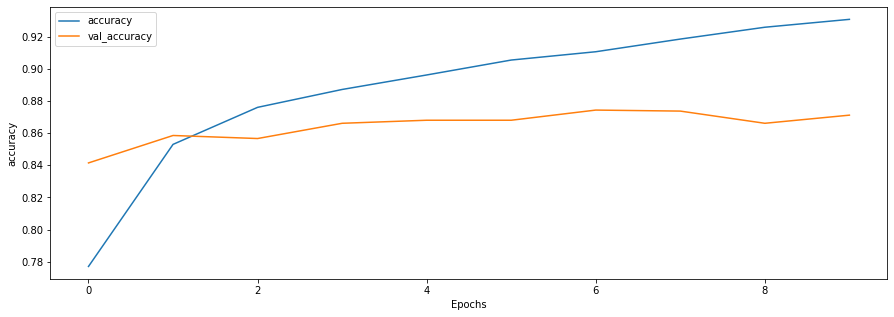

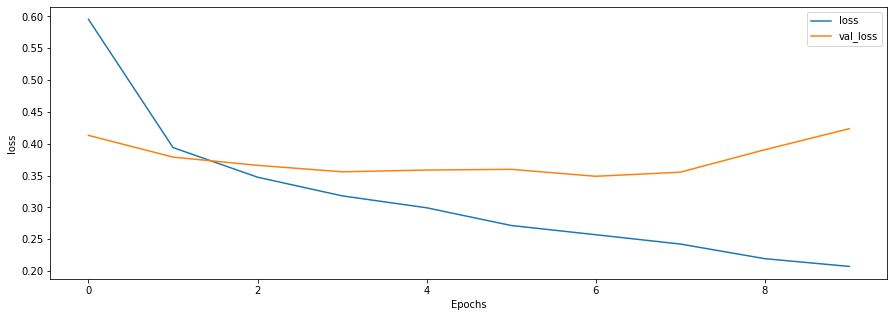

In [36]:
def plot_graphs(history, string):
  fig = plt.figure(figsize=(15, 5))
  name_img = string + '_' + str(lr).replace('.', '') + '_' + str(MAX_SEQUENCE_LENGTH) + '_' + str(BATCH_SIZE) + '_' + str(DROPOUT).replace('.', '') + '_' + str(f1).replace('.', '') + '.png'
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  fig.savefig(os.path.join(path_img, name_img), bbox_inches='tight') 
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

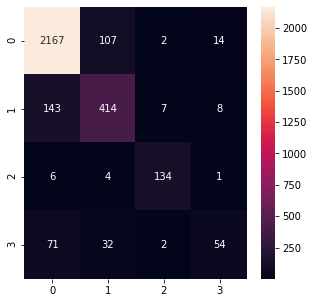

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def _confusion_matrix(Y_test, y_pred, metric, name_model, path_img=path_img):
  f1 = round(metric['macro avg']['f1-score'], 4)
  name_img = 'CM_' + name_model + '_' + str(f1).replace('.', '') + '.png' 
  cf_matrix = confusion_matrix(Y_test, y_pred)
  fig = plt.figure(figsize=(5, 5))
  sns.heatmap(cf_matrix, annot=True, fmt='g')
  sns.set(font_scale=1)
  fig.savefig(os.path.join(path_img, name_img), bbox_inches='tight')
  plt.show()

_confusion_matrix(Y_test, y_pred, metric, name_model)

In [38]:
from sklearn.metrics import f1_score, recall_score, precision_score

print("BiLSTM + Pho2WV:", f1_score(Y_test, y_pred, average='micro'))
print("BiLSTM + Pho2WV:", recall_score(Y_test, y_pred, average='micro'))
print("BiLSTM + Pho2WV:", precision_score(Y_test, y_pred, average='micro'))

BiLSTM + Pho2WV: 0.8746051800379027
BiLSTM + Pho2WV: 0.8746051800379027
BiLSTM + Pho2WV: 0.8746051800379027
